# Speed Dating Data
https://www.kaggle.com/annavictoria/speed-dating-experiment

# 3 Feature Engineering/Pre-processing & Modeling (ver. keep chosen categorical columns), male decision


## 3.1  Imports

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
from scipy import stats

from sb_utils import save_file

In [23]:
# not sure if I need this
import datetime
import unicodedata
import re
from sklearn.preprocessing import scale

## 3.2 Objectives

In the data wrangling notebook, we have identified our target dependent variable as desicion of parner of the specific subject, dec_o (might also consider match, desicion from both the subject and the partner) and cleaned the data accordingly. In this notebook, we will conduct further EDA, hoping to answer following questions.

1. The difference of desirable attributes in a male partner vs female partner.
2. The difference of desirable attributes among  races.
3. The difference of desirable major of male partner vs female partner
4. The difference of desirable majors among races.  

**Learning Objectives**:
Preprocessing:
1. Understand the importance of creating a model training development data set.
2. Correctly identify when to create dummy features or one-hot encoded features.
3. Understand the importance of magnitude standardization.
4. Apply the train and test split to the development dataset effectively

Modeling:
1. Fit your models with a training dataset 
    - Use cross-validation for hyperparameter tuning
2. Review model outcomes — Iterate over additional models as needed
    - Caclulate accuracy, recall, precision, and F1.
3. Identify the final model that you think is the best model for this project
    - Most power model interms of model evaluation metrics, computational complexity, scalability, and maintenance costs.

Here is possible workflow: TBD
1. Pre-processing:
    - Removed columns with categorical meaning before fillna with mean
    - Got dummy variables for all the columns with categorical meaning and with missing data
        - Converted the type int/float to object beforehand.
        - Make sure to use pd.get_dummies(df, drop_first=False), without dropping rows with missing values. Leave the first column so that missing value information is not lost.  Missing value can be considered as a category label as its own.
        - Removed the original categorical columns with missing data
    - Split into training/test set > fill NaN with mean, scale within training set and test set separately
        - Extract columns with numeric meaning to scale
        - Removed dummy variables columns and binary columns before scaling the numeric columns
        - Combined the dummy variable columns, binary columns and scaled numeric columns per train set and test set.
    - perform PCA on scaled numeric columns to reduce dimension
        - Keep enough pca components to explain ~90% var. 
        - Combined the dummy variable columns, binary columns and pca columns from scaled numeric columns
2. Modeling:
    - logistic regression model via sklearn and statsmodel
        - Use GridSearchCV (cv=5) for feature engineering
        - Use stepwise selection, elastic-net (or L1/L2 regularizers) if possible
    - Random Forest model via sklearn
    - Compare all models using confusion matrix and classification report
3. Feature importance analysis
    - Use SHAP for sklearn model
    - in order to answer feature importance for Male and Female, ran the model with male data and female data separately (done).
    - in ordr to answer feature importance for different races, can run the model with each race seprately (not done)

## 3.3 Load The Data

In [24]:
# df = pd.read_csv('../data/ski_data_cleaned.csv')
spd = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_cleaned.csv') #spd1_2 in data wrangling notebook
# spd_fp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_FemaleRatingMale_cleaned.csv') # spd1_2fp in data wrangling notebook 
spd_mp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_MaleRatingFemale_cleaned.csv') # spd1_2mp in data wrangling notebook

In [25]:
spd.shape

(6266, 24)

In [26]:
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.14,0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.54,0,...,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.16,1,...,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.61,0,...,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.21,0,...,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0


In [27]:
spd = spd_mp

In [28]:
spd.shape

(3128, 24)

In [29]:
# gender = 1 = male subject = female pertner = female dec_o
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.14,0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.54,0,...,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.16,1,...,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.61,0,...,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.21,0,...,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0


In [30]:
spd.gender.unique()

array([0], dtype=int64)

In [31]:
spd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    3128 non-null   int64  
 1   match     3128 non-null   int64  
 2   age       3090 non-null   float64
 3   race      3090 non-null   float64
 4   field     3090 non-null   object 
 5   career    3064 non-null   object 
 6   from      3074 non-null   object 
 7   goal      3074 non-null   float64
 8   int_corr  3054 non-null   float64
 9   samerace  3128 non-null   int64  
 10  imprace   3074 non-null   float64
 11  imprelig  3074 non-null   float64
 12  age_o     3099 non-null   float64
 13  race_o    3108 non-null   float64
 14  dec_o     3128 non-null   int64  
 15  attr_o    3062 non-null   float64
 16  sinc_o    3025 non-null   float64
 17  intel_o   3021 non-null   float64
 18  fun_o     3004 non-null   float64
 19  amb_o     2857 non-null   float64
 20  shar_o    2728 non-null   floa

In [32]:
# check for NaN
spd.isna().sum() 
# need to remove cotegorical feature with type int or float before fill NaN with mean
# remove: race, goal, race_o, met_o > leave put to be dealt with dummy variables

gender        0
match         0
age          38
race         38
field        38
career       64
from         54
goal         54
int_corr     74
samerace      0
imprace      54
imprelig     54
age_o        29
race_o       20
dec_o         0
attr_o       66
sinc_o      103
intel_o     107
fun_o       124
amb_o       271
shar_o      400
like_o       66
prob_o       99
met_o       128
dtype: int64

In [33]:
# check for column value range
spd.describe()

,gender,match,age,race,goal,int_corr,samerace,imprace,imprelig,age_o,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
count,3128.0,3128.000000,3090.000000,3090.000000,3074.000000,3054.000000,3128.000000,3074.000000,3074.000000,3099.000000,...,3128.000000,3062.000000,3025.000000,3021.000000,3004.000000,2857.00000,2728.00000,3062.000000,3029.000000,3000.000000
mean,0.0,0.171036,26.079288,2.709709,2.078399,0.192980,0.405691,4.154847,4.362394,26.450468,...,0.495205,6.489843,7.237190,7.270275,6.491844,6.59608,5.60154,6.269497,5.225817,1.955333
std,0.0,0.376600,3.636065,1.235156,1.360513,0.304001,0.491104,3.048917,2.896764,3.394121,...,0.500057,1.845334,1.613289,1.463131,1.852454,1.71068,2.07782,1.764430,2.130373,0.229541
min,0.0,0.000000,19.000000,1.000000,1.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,0.00000,1.000000,0.000000,1.000000
25%,0.0,0.000000,23.000000,2.000000,1.000000,-0.010000,0.000000,1.000000,2.000000,24.000000,...,0.000000,5.000000,6.000000,6.000000,5.000000,5.00000,4.00000,5.000000,4.000000,2.000000
50%,0.0,0.000000,26.000000,2.000000,2.000000,0.210000,0.000000,3.000000,4.000000,27.000000,...,0.000000,7.000000,7.000000,7.000000,7.000000,7.00000,6.00000,6.000000,5.000000,2.000000
75%,0.0,0.000000,28.000000,4.000000,2.000000,0.430000,1.000000,7.000000,6.000000,28.000000,...,1.000000,8.000000,8.000000,8.000000,8.000000,8.00000,7.00000,7.000000,7.000000,2.000000
max,0.0,1.000000,38.000000,6.000000,6.000000,0.900000,1.000000,10.000000,10.000000,42.000000,...,1.000000,10.000000,10.000000,10.000000,11.000000,10.00000,10.00000,10.000000,10.000000,7.000000


In [34]:
# met_o supposed to be binary (1 or 2) column but it was not. double check its unique value
spd.met_o.unique() # people might have mistakenly input how many times have met before?

array([ 2.,  1., nan,  7.])

In [35]:
# check the value of categorical columns we want to get dummy variables
spd.race.unique()

array([ 4.,  2.,  6.,  1.,  3., nan])

In [36]:
spd.race_o.unique()

array([ 2.,  4.,  3.,  1.,  6., nan])

In [37]:
spd.field.unique() # too much but want to keep it for now

array(['Law', 'law', 'Economics', 'Masters in Public Administration',
       'Masters of Social Work&Education', 'Operations Research',
       'TC (Health Ed)', 'Psychology', 'social work', 'Social Work',
       'Speech Language Pathology', 'Speech Languahe Pathology',
       'Educational Psychology', 'Applied Maths/Econs', 'Mathematics',
       'Statistics', 'Organizational Psychology', nan, 'psychology',
       'German Literature', 'Classics', 'Operations Research (SEAS)',
       'chemistry', 'Journalism', 'Elementary/Childhood Education (MA)',
       'microbiology', 'Masters of Social Work', 'Communications',
       'Marketing', 'Chemistry', 'International Educational Development',
       'Education Administration', 'Sociology', 'Economics, English',
       'political science', 'Economics, Sociology', 'Polish', 'English',
       'psychology and english', 'Nutrition/Genetics', 'Neuroscience',
       'Comparative Literature', 'Business', 'International Relations',
       'History of R

In [38]:
spd['from'].unique() # spd.from.unique() didn't work, too much options > drop b/c less interested

array(['Chicago', 'Alabama', 'Connecticut', 'Texas', 'Bowdoin College',
       'MD', 'Southern California', 'London, England',
       'Palm Springs, California', '94115', 'New Jersey', 'Ann Arbor, MI',
       'Hong Kong', 'new york', 'Iowa', 'California', 'Westchester, NY',
       nan, 'Washington, DC', 'Boston', 'new jersey', 'Michigan',
       'SIngapore', 'Brazil', 'Brandeis University', 'Cincinnati, OH',
       'New York', 'Los Angeles', 'Florida', 'Tuscaloosa, Alabama',
       'Albuquerque, NM', 'Palo Alto, California', 'Boston, MA', 'Ohio',
       'Minnesota', 'India/Venezuela', 'China', 'Washington State',
       'Panama', 'spain', 'Arizona', 'Minneapolis, MN', 'NJ', 'NY',
       'Israel', 'P. R. China', 'San Francisco', 'England',
       'Milwaukee, Wisconsin', 'brooklyn ny', 'France', 'Long Island, NY',
       'Puerto Rico', 'Memphis, TN', 'california', 'Albania', 'PA',
       'Cherry Hill, NJ', 'Minneapolis', 'NYC', 'ottawa, canada',
       'Philadelphia, PA', 'Atlanta, GA', 

In [39]:
spd.career.unique() # too much options... this is 'intended' career > drop will keep filed instead 
# if want to include this, can reduce the option by merging similar ones.

array(['lawyer', 'law', 'Economist', 'lawyer/policy work', 'Law',
       'Journalist', 'Congresswoman, and comedian',
       'To create early childhood intervention programs', 'Undecided',
       'Informatics', 'psychologist',
       'health/nutrition oriented social worker', 'Social Worker',
       'Social work with children', 'Speech Language Pathologist', nan,
       'Social Work Administration', 'Lawyer', 'Professor',
       "Clidren's TV", 'Banking', 'Capital Markets', 'Biostatistics',
       'Organizational Change Consultant', 'social worker', 'comedienne',
       'Academic', 'attorney', 'Social Worker.... Clinician', 'teacher',
       'Counseling Adolescents', 'Operations Research',
       'industrial scientist', 'Journalism', 'teaching and then...',
       'Economic research', 'pharmaceuticals', 'Social Services/ Policy',
       'Professor of Media Studies', 'Clinical Social Worker',
       "I don't know", 'Microfinancing Program Manager',
       'Education Administration', 'So

In [41]:
spd.goal.unique() # goal for attending this speed dating, not many options so will keep

array([ 2.,  1.,  6., nan,  5.,  3.,  4.])

## 3.4 Pre-processing data

### 3.4.1 Get dummy variables of chosen categorical columns

In [42]:
# exctract categorical data
# refer to '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk'
# dfo = df.select_dtypes(include='object')
# spd1 = spd[['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o']]  
#%%%%% converting all this features to variables took forever to run the ML model
spd1 = spd[['race', 'field', 'goal', 'race_o', 'met_o']]  # dropped less interested features
# did not include 'gender' and 'match' columns b/c they are binary column w/o missing data
spd1.head()

,race,field,goal,race_o,met_o
0,4.0,Law,2.0,2.0,2.0
1,4.0,Law,2.0,2.0,2.0
2,4.0,Law,2.0,4.0,1.0
3,4.0,Law,2.0,2.0,2.0
4,4.0,Law,2.0,3.0,2.0


In [43]:
# check column type
spd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    3090 non-null   float64
 1   field   3090 non-null   object 
 2   goal    3074 non-null   float64
 3   race_o  3108 non-null   float64
 4   met_o   3000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 122.3+ KB


In [44]:
# convert to object type 
spd1_o = spd1.astype('object') #%%%%% get_dummies did not work on int/float type
spd1_o.head()

,race,field,goal,race_o,met_o
0,4,Law,2,2,2
1,4,Law,2,2,2
2,4,Law,2,4,1
3,4,Law,2,2,2
4,4,Law,2,3,2


In [45]:
# check column type
spd1_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    3090 non-null   object
 1   field   3090 non-null   object
 2   goal    3074 non-null   object
 3   race_o  3108 non-null   object
 4   met_o   3000 non-null   object
dtypes: object(5)
memory usage: 122.3+ KB


In [46]:
# get dummy variable from the exctracted categorical data
# refer to 14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
spd1_odm = pd.get_dummies(spd1_o) # since spd1_o categorial type features still have many missing data, kept drop_first=False
spd1_odm.head() # pd.get_dummies() automatically removed the orignal categorical variables

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,goal_5.0,goal_6.0,race_o_1.0,race_o_2.0,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_7.0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [47]:
# check for NaN
spd1_odm.isna().sum()

race_1.0      0
race_2.0      0
race_3.0      0
race_4.0      0
race_6.0      0
             ..
race_o_4.0    0
race_o_6.0    0
met_o_1.0     0
met_o_2.0     0
met_o_7.0     0
Length: 146, dtype: int64

In [48]:
spd1_odm.shape

(3128, 146)

In [49]:
# extract the numeric data
spd2 = spd.drop(columns=['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o'])
spd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    3128 non-null   int64  
 1   match     3128 non-null   int64  
 2   age       3090 non-null   float64
 3   int_corr  3054 non-null   float64
 4   samerace  3128 non-null   int64  
 5   imprace   3074 non-null   float64
 6   imprelig  3074 non-null   float64
 7   age_o     3099 non-null   float64
 8   dec_o     3128 non-null   int64  
 9   attr_o    3062 non-null   float64
 10  sinc_o    3025 non-null   float64
 11  intel_o   3021 non-null   float64
 12  fun_o     3004 non-null   float64
 13  amb_o     2857 non-null   float64
 14  shar_o    2728 non-null   float64
 15  like_o    3062 non-null   float64
 16  prob_o    3029 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 415.6 KB


In [50]:
# add these dummy variables back to the numeric data
# make sure to remove the original categorical data with missing data: field, career, from, 'race', 'goal', 'race_o', 'met_o'
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
spd_odm = pd.merge(spd1_odm, spd2, left_index=True, right_index=True)
print(spd_odm.shape)
spd_odm.head()

(3128, 163)


,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,age_o,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,27.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,22.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,22.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,23.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,24.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [51]:
# check NaN
spd_odm.isna().sum() 

race_1.0      0
race_2.0      0
race_3.0      0
race_4.0      0
race_6.0      0
           ... 
fun_o       124
amb_o       271
shar_o      400
like_o       66
prob_o       99
Length: 163, dtype: int64

### 3.4.2 Set up/Split input data (X and y) into test set and train set

In [52]:
# spd_odm
X = spd_odm.drop(columns='dec_o')
y = spd_odm['dec_o']

In [53]:
# check
X.shape, y.shape

((3128, 162), (3128,))

In [54]:
X.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,4.0,27.0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,4.0,23.0,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,4.0,24.0,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [55]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: dec_o, dtype: int64

In [56]:
# Split the data into a training and test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
X_train.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
1271,0,1,0,0,0,0,0,0,0,0,...,1.0,28.0,5.0,7.0,7.0,6.0,6.0,6.0,5.0,6.0
2816,0,1,0,0,0,0,0,0,0,0,...,2.0,31.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1459,0,1,0,0,0,0,0,0,0,0,...,10.0,26.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,6.0
1973,0,1,0,0,0,0,0,0,0,0,...,10.0,27.0,6.0,7.0,7.0,5.0,3.0,4.0,8.0,4.0
2761,0,1,0,0,0,0,0,0,0,0,...,8.0,29.0,6.0,7.0,7.0,8.0,NaN,NaN,6.0,4.0


In [58]:
X_test.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
2753,0,1,0,0,0,0,0,0,0,0,...,6.0,23.0,7.0,9.0,8.0,8.0,7.0,6.0,8.0,7.0
2545,0,1,0,0,0,0,0,0,0,0,...,2.0,24.0,7.0,8.0,7.0,8.0,7.0,7.0,6.0,6.0
178,0,1,0,0,0,0,0,0,0,0,...,2.0,28.0,8.0,9.0,9.0,9.0,7.0,5.0,7.0,5.0
1502,0,1,0,0,0,0,0,0,0,0,...,5.0,27.0,7.0,5.0,6.0,8.0,2.0,4.0,5.0,4.0
2727,0,1,0,0,0,0,0,0,0,0,...,5.0,29.0,7.0,9.0,5.0,7.0,5.0,6.0,8.0,9.0


In [59]:
# reset index
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
X_train = X_train.reset_index(drop=True)
X_train.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,1.0,28.0,5.0,7.0,7.0,6.0,6.0,6.0,5.0,6.0
1,0,1,0,0,0,0,0,0,0,0,...,2.0,31.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,0,1,0,0,0,0,0,0,0,0,...,10.0,26.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,6.0
3,0,1,0,0,0,0,0,0,0,0,...,10.0,27.0,6.0,7.0,7.0,5.0,3.0,4.0,8.0,4.0
4,0,1,0,0,0,0,0,0,0,0,...,8.0,29.0,6.0,7.0,7.0,8.0,NaN,NaN,6.0,4.0


In [60]:
X_test = X_test.reset_index(drop=True)
X_test.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,field_Art Education,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,6.0,23.0,7.0,9.0,8.0,8.0,7.0,6.0,8.0,7.0
1,0,1,0,0,0,0,0,0,0,0,...,2.0,24.0,7.0,8.0,7.0,8.0,7.0,7.0,6.0,6.0
2,0,1,0,0,0,0,0,0,0,0,...,2.0,28.0,8.0,9.0,9.0,9.0,7.0,5.0,7.0,5.0
3,0,1,0,0,0,0,0,0,0,0,...,5.0,27.0,7.0,5.0,6.0,8.0,2.0,4.0,5.0,4.0
4,0,1,0,0,0,0,0,0,0,0,...,5.0,29.0,7.0,9.0,5.0,7.0,5.0,6.0,8.0,9.0


In [61]:
#%%%% should rest_index for statsmodel input to avoid 'ValueError: The indices for endog and exog are not aligned'
#%%%% make sure to 'drop=True' to keep y as 1d array (2d array etc will cause error as input for sklearn).
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
y_train.shape, y_test.shape

((2502,), (626,))

In [62]:
y_train

0       0
1       1
2       1
3       1
4       1
       ..
2497    0
2498    1
2499    0
2500    0
2501    1
Name: dec_o, Length: 2502, dtype: int64

### 3.4.3 Filling NaN of numeric data with mean

In [63]:
y.isna().sum() # no need to clean 

0

In [64]:
# extract categorial data & binary data without missing data
X_train1 = X_train.loc[:, 'race_1.0':'match']
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Columns: 148 entries, race_1.0 to match
dtypes: int64(2), uint8(146)
memory usage: 395.9 KB


In [65]:
X_test1 = X_test.loc[:, 'race_1.0':'match']
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Columns: 148 entries, race_1.0 to match
dtypes: int64(2), uint8(146)
memory usage: 99.2 KB


In [66]:
# check for NaN
X_train1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [67]:
X_test1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [68]:
# extract the numeric data with missing data
X_train2 = X_train.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2474 non-null   float64
 1   int_corr  2447 non-null   float64
 2   samerace  2502 non-null   int64  
 3   imprace   2461 non-null   float64
 4   imprelig  2461 non-null   float64
 5   age_o     2480 non-null   float64
 6   attr_o    2448 non-null   float64
 7   sinc_o    2420 non-null   float64
 8   intel_o   2417 non-null   float64
 9   fun_o     2407 non-null   float64
 10  amb_o     2289 non-null   float64
 11  shar_o    2192 non-null   float64
 12  like_o    2450 non-null   float64
 13  prob_o    2419 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 273.8 KB


In [69]:
X_test2 = X_test.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       616 non-null    float64
 1   int_corr  607 non-null    float64
 2   samerace  626 non-null    int64  
 3   imprace   613 non-null    float64
 4   imprelig  613 non-null    float64
 5   age_o     619 non-null    float64
 6   attr_o    614 non-null    float64
 7   sinc_o    605 non-null    float64
 8   intel_o   604 non-null    float64
 9   fun_o     597 non-null    float64
 10  amb_o     568 non-null    float64
 11  shar_o    536 non-null    float64
 12  like_o    612 non-null    float64
 13  prob_o    610 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 68.6 KB


In [70]:
# fill mean within train set
X_train2_mean = X_train2.fillna(X_train2.mean())
# check for NaN
X_train2_mean.isna().sum(), X_train2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (2502, 14))

In [71]:
# fill mean within test set
X_test2_mean = X_test2.fillna(X_test2.mean())
# check for NaN
X_test2_mean.isna().sum(), X_test2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (626, 14))

### 3.4.4 Scale continuous numeric features (leaving out the target, binary, and categorical features)

In [72]:
# check range
X_train2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,26.055780,0.194638,0.402478,4.161723,4.367737,26.467742,6.496324,7.239050,7.292718,6.502077,6.619484,5.616560,6.274980,5.230674
std,3.627293,0.299297,0.490495,3.006699,2.865658,3.383133,1.836474,1.615036,1.451557,1.838109,1.632288,1.963274,1.766445,2.113747
min,19.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,23.000000,-0.010000,0.000000,1.000000,2.000000,24.000000,5.000000,6.000000,6.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.200000,0.000000,3.000000,4.000000,27.000000,6.750000,7.000000,7.000000,7.000000,6.619484,5.616560,6.000000,5.000000
75%,28.000000,0.420000,1.000000,7.000000,6.000000,28.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,38.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.000000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000


In [73]:
X_test2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000
mean,26.173701,0.186293,0.418530,4.127243,4.340946,26.381260,6.464007,7.229752,7.180464,6.450586,6.501761,5.540112,6.247549,5.206557
std,3.561216,0.304833,0.493713,3.087024,2.897652,3.360958,1.783486,1.468095,1.379466,1.722228,1.643410,1.846462,1.661443,2.027007
min,19.000000,-0.630000,0.000000,1.000000,1.000000,18.000000,1.000000,2.000000,3.000000,1.000000,2.000000,0.000000,1.000000,0.000000
25%,24.000000,-0.020000,0.000000,1.000000,2.000000,24.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,4.000000
50%,26.000000,0.186293,0.000000,3.000000,4.000000,27.000000,6.464007,7.000000,7.000000,6.450586,6.501761,5.540112,6.000000,5.000000
75%,28.000000,0.437500,1.000000,7.000000,6.000000,28.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,38.000000,0.850000,1.000000,10.000000,10.000000,42.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [74]:
# drop samerace, binary feature without missing data
X_train3_mean = X_train2_mean.drop(columns='samerace')
X_test3_mean = X_test2_mean.drop(columns='samerace')

In [75]:
# refer to '6_GuidedCapstone/04_preprocessing_and_training_mk'
# refer to '16.3.1_Capstone_Two_Step_4__Preprocessing_Training_Data_Development.pdf'
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk.ipynb'
from sklearn.preprocessing import StandardScaler
# Making a Scaler object based on train set and apply it to test set to scale the test set
scaler = StandardScaler().fit(X_train3_mean)

# apply the scaler to train set
X_train_mean_scaled = scaler.transform(X_train3_mean)
print(type(X_train_mean_scaled))
X_train_mean_scaled = pd.DataFrame(X_train_mean_scaled, columns=X_train3_mean.columns)
X_train_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-0.566866,0.786538,-1.051770,-1.175440,0.453001,-0.814943,-0.148045,-0.201698,-0.273203,-0.379595,0.195345,-0.721922,0.364036
1,-0.291124,0.953629,0.278859,-0.826411,1.339931,-0.814943,-1.386655,-1.579805,-0.817350,-0.992355,-0.314110,-0.721922,-0.109152
2,-1.118352,-0.349683,-0.053798,1.965828,-0.138285,0.274318,-0.148045,-0.201698,0.270943,-0.379595,0.704800,0.410523,0.364036
3,0.811847,0.485773,-1.051770,1.965828,0.157358,-0.270313,-0.148045,-0.201698,-0.817350,-2.217874,-0.823565,0.976745,-0.582340
4,-0.291124,0.920211,0.278859,1.267768,0.748645,-0.270313,-0.148045,-0.201698,0.815089,0.000000,0.000000,-0.155700,-0.582340


In [76]:
# apply the scaler to test set
X_test_mean_scaled = scaler.transform(X_test3_mean)
print(type(X_test_mean_scaled))
X_test_mean_scaled = pd.DataFrame(X_test_mean_scaled, columns=X_test3_mean.columns)
X_test_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-0.842609,-0.449938,1.609488,0.569709,-1.025214,0.274318,1.090566,0.487355,0.815089,0.233165,0.195345,0.976745,0.837224
1,-0.566866,-0.449938,1.942145,-0.826411,-0.729571,0.274318,0.471260,-0.201698,0.815089,0.233165,0.704800,-0.155700,0.364036
2,-0.291124,-1.151722,1.942145,-0.826411,0.453001,0.818948,1.090566,1.176408,1.359235,0.233165,-0.314110,0.410523,-0.109152
3,-0.842609,1.321230,0.278859,0.220679,0.157358,0.274318,-1.386655,-0.890752,0.815089,-2.830634,-0.823565,-0.721922,-0.582340
4,0.260362,-0.316265,1.942145,0.220679,0.748645,0.274318,1.090566,-1.579805,0.270943,-0.992355,0.195345,0.976745,1.783600


In [77]:
# check size
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((2502, 13), (626, 13))

In [78]:
# Combine scaled features + dummy variabls + the original binary features
# X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
print(X_train_odmb.shape)
X_train_mean_scaled_odmb = pd.merge(X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(X_train_mean_scaled_odmb.shape)
X_train_mean_scaled_odmb.head() 

(2502, 149)
(2502, 162)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,race_o_2.0,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_7.0,gender,match,samerace
0,-0.566866,0.786538,-1.051770,-1.175440,0.453001,-0.814943,-0.148045,-0.201698,-0.273203,-0.379595,...,1,0,0,0,0,1,0,0,0,1
1,-0.291124,0.953629,0.278859,-0.826411,1.339931,-0.814943,-1.386655,-1.579805,-0.817350,-0.992355,...,1,0,0,0,0,1,0,0,0,1
2,-1.118352,-0.349683,-0.053798,1.965828,-0.138285,0.274318,-0.148045,-0.201698,0.270943,-0.379595,...,1,0,0,0,0,1,0,0,0,1
3,0.811847,0.485773,-1.051770,1.965828,0.157358,-0.270313,-0.148045,-0.201698,-0.817350,-2.217874,...,1,0,0,0,0,1,0,0,0,1
4,-0.291124,0.920211,0.278859,1.267768,0.748645,-0.270313,-0.148045,-0.201698,0.815089,0.000000,...,1,0,0,0,0,1,0,0,1,1


In [79]:
# X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
print(X_test_odmb.shape)
#X_train_odmb.head()
X_test_mean_scaled_odmb = pd.merge(X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(X_test_mean_scaled_odmb.shape)
X_test_mean_scaled_odmb.head() #%%%%%% why the row number discreased??

(626, 149)
(626, 162)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,race_o_2.0,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_7.0,gender,match,samerace
0,-0.842609,-0.449938,1.609488,0.569709,-1.025214,0.274318,1.090566,0.487355,0.815089,0.233165,...,1,0,0,0,0,1,0,0,1,1
1,-0.566866,-0.449938,1.942145,-0.826411,-0.729571,0.274318,0.471260,-0.201698,0.815089,0.233165,...,0,0,0,1,0,1,0,0,0,0
2,-0.291124,-1.151722,1.942145,-0.826411,0.453001,0.818948,1.090566,1.176408,1.359235,0.233165,...,1,0,0,0,0,1,0,0,0,1
3,-0.842609,1.321230,0.278859,0.220679,0.157358,0.274318,-1.386655,-0.890752,0.815089,-2.830634,...,1,0,0,0,0,1,0,0,0,1
4,0.260362,-0.316265,1.942145,0.220679,0.748645,0.274318,1.090566,-1.579805,0.270943,-0.992355,...,0,0,1,0,0,1,0,0,0,0


### 3.4.5 Use PCA for demension reduction of numeric features

In [80]:
# check size of numeric features 
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((2502, 13), (626, 13))

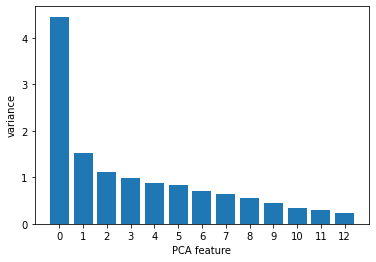

In [81]:
# refer to '15.4.3_3_Unsupervised Learning_Dimension reduction'
# Create a PCA instance: pca
pca = PCA()

# Fit model to numeric features
pca.fit(X_train_mean_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

It looks like PCA features 0 have the most significant variance (first elbow). Will keep PCA features 0 - 3 (2nd elbow) for more variance to be conservative.

In [82]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_train_mean_scaled)

# Transform the numeric features: pca_features
pca_X_train_mean_scaled = pca.transform(X_train_mean_scaled)

# Print the shape of pca_features
print(pca_X_train_mean_scaled.shape)
print(type(pca_X_train_mean_scaled))
pca_X_train_mean_scaled = pd.DataFrame(pca_X_train_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_train_mean_scaled.head()

(2502, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,0.705330,-1.244576,-0.208457,-0.803189
1,2.351912,-0.353397,0.908782,-1.037971
2,-0.462352,1.779257,0.101486,-0.480285
3,1.390396,-0.142292,1.147205,-0.338220
4,0.093828,0.684923,1.340301,-0.369419


In [83]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_test_mean_scaled)

# Transform the numeric features: pca_features
pca_X_test_mean_scaled = pca.transform(X_test_mean_scaled)

# Print the shape of pca_features
print(pca_X_test_mean_scaled.shape)
print(type(pca_X_test_mean_scaled))
pca_X_test_mean_scaled = pd.DataFrame(pca_X_test_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_test_mean_scaled.head()

(626, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-1.819384,1.992526,0.567054,-0.093658
1,-1.005047,1.188998,0.871934,0.076554
2,-1.848644,1.206156,0.216763,1.006964
3,1.995219,0.352858,-0.060008,-2.208329
4,-0.729049,1.516086,-0.376072,-1.106624


In [84]:
# Combine pca scaled features + dummy variabls + the original binary features
# pca_X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
# print(X_train_odmb.shape)
pca_X_train_mean_scaled_odmb = pd.merge(pca_X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(pca_X_train_mean_scaled_odmb.shape)
pca_X_train_mean_scaled_odmb.head() 

(2502, 153)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,race_o_2.0,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_7.0,gender,match,samerace
0,0.705330,-1.244576,-0.208457,-0.803189,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,2.351912,-0.353397,0.908782,-1.037971,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,-0.462352,1.779257,0.101486,-0.480285,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,1.390396,-0.142292,1.147205,-0.338220,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0.093828,0.684923,1.340301,-0.369419,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,1


In [85]:
# pca_X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
# print(X_test_odmb.shape)
# X_train_odmb.head()
pca_X_test_mean_scaled_odmb = pd.merge(pca_X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(pca_X_test_mean_scaled_odmb.shape)
pca_X_test_mean_scaled_odmb.head() 

(626, 153)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,race_o_2.0,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_7.0,gender,match,samerace
0,-1.819384,1.992526,0.567054,-0.093658,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,1
1,-1.005047,1.188998,0.871934,0.076554,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,-1.848644,1.206156,0.216763,1.006964,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,1.995219,0.352858,-0.060008,-2.208329,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,-0.729049,1.516086,-0.376072,-1.106624,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


## 3.5 Fit Model 

### 3.5.1 LogisticRegression via sklearn

In [86]:
# make sure the y input for sklearn model is 1d array
y_train.shape, y_test.shape

((2502,), (626,))

In [87]:
np.logspace(-5, 8, 15)

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

#### 3.5.1.1 numeric features without PCA

In [88]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred0))
print(classification_report(y_test, y_pred0))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8185405189620759
Accuracy on training data: 0.85
Accuracy on test data:     0.83
[[268  48]
 [ 57 253]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       316
           1       0.84      0.82      0.83       310

    accuracy                           0.83       626
   macro avg       0.83      0.83      0.83       626
weighted avg       0.83      0.83      0.83       626

Wall time: 41.6 s


In [89]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1)
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best1 = logreg_cv.best_estimator_
training_accuracy = logreg_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred1 = logreg_best1.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.8, 'penalty': 'elasticnet'}
Best score is 0.8245389221556886
Accuracy on training data: 0.84
Accuracy on test data:     0.83
[[269  47]
 [ 59 251]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       316
           1       0.84      0.81      0.83       310

    accuracy                           0.83       626
   macro avg       0.83      0.83      0.83       626
weighted avg       0.83      0.83      0.83       626

Wall time: 21min 38s


#### 3.5.1.2 numeric features with PCA

In [90]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best2 = logreg_cv.best_estimator_
training_accuracy = logreg_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred2 = logreg_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.7861788423153693
Accuracy on training data: 0.82
Accuracy on test data:     0.78
[[255  61]
 [ 77 233]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       316
           1       0.79      0.75      0.77       310

    accuracy                           0.78       626
   macro avg       0.78      0.78      0.78       626
weighted avg       0.78      0.78      0.78       626

Wall time: 36 s


In [91]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best3 = logreg_cv.best_estimator_
training_accuracy = logreg_best3.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best3.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred3 = logreg_best3.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.30000000000000004, 'penalty': 'elasticnet'}
Best score is 0.7905700598802395
Accuracy on training data: 0.81
Accuracy on test data:     0.79
[[264  52]
 [ 81 229]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       316
           1       0.81      0.74      0.77       310

    accuracy                           0.79       626
   macro avg       0.79      0.79      0.79       626
weighted avg       0.79      0.79      0.79       626

Wall time: 18min 36s


### 3.5.2 LogisticRegression via statsmodels

#### 3.5.2.1 numeric features without PCA

Higher the Pseudo R-squ.score, the better the model is. Adding constant may improve the Pseudo R-squ.

In [92]:
# statsmodel w/ constant & penalty term
# Import the statsmodels module
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'
import statsmodels.api as sm

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
X_train_mean_scaled_odmb_c = sm.add_constant(X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
X_test_mean_scaled_odmb_c = sm.add_constant(X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
X_train_mean_scaled_odmb_c_dirty = X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(X_train_mean_scaled_odmb_c.shape[0], X_train_mean_scaled_odmb_c.shape[1])
X_test_mean_scaled_odmb_c_dirty = X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(X_test_mean_scaled_odmb_c.shape[0], X_test_mean_scaled_odmb_c.shape[1])
                
# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3077886904517683
            Iterations: 557
            Function evaluations: 557
            Gradient evaluations: 557


In [93]:
# printing the summary table 
print(log_reg1.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 2502
Model:                          Logit   Df Residuals:                     2339
Method:                           MLE   Df Model:                          162
Date:                Sat, 24 Apr 2021   Pseudo R-squ.:                  0.5559
Time:                        00:54:06   Log-Likelihood:                -770.09
converged:                       True   LL-Null:                       -1734.1
Covariance Type:            nonrobust   LLR p-value:                1.692e-299
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                            -24.2385    148.847     -0.163      0.871

In [94]:
# Predict the labels of the test data: y_pred
y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)

In [95]:
type(y_pred1)

pandas.core.series.Series

In [96]:
y_pred1

0      1.000000
1      0.375412
2      0.601753
3      0.863981
4      0.974641
         ...   
621    0.046592
622    0.678649
623    0.193072
624    0.709022
625    0.150247
Length: 626, dtype: float64

In [97]:
# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred1_df = pd.DataFrame({'probability': y_pred1})
print(y_pred1_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred1_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred1_df.probability] 
#%%%% y_pred1_df.prediction = [list comprehenshion] did not work!
y_pred1_df 

     probability
0       1.000000
1       0.375412
2       0.601753
3       0.863981
4       0.974641
..           ...
621     0.046592
622     0.678649
623     0.193072
624     0.709022
625     0.150247

[626 rows x 1 columns]


,probability,prediction
0,1.000000,1
1,0.375412,0
2,0.601753,1
3,0.863981,1
4,0.974641,1
...,...,...
621,0.046592,0
622,0.678649,1
623,0.193072,0
624,0.709022,1


In [98]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1_df.prediction))
print(classification_report(y_test, y_pred1_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

[[268  48]
 [ 57 253]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       316
           1       0.84      0.82      0.83       310

    accuracy                           0.83       626
   macro avg       0.83      0.83      0.83       626
weighted avg       0.83      0.83      0.83       626



Overall scores are little lower than sklearn model but runs much faster (10-20min?)

#### 3.5.2.2 numeric features with PCA

In [99]:
# statsmodel w/ constant & penalty term
# Import the statsmodels module
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'
import statsmodels.api as sm

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
pca_X_train_mean_scaled_odmb_c = sm.add_constant(pca_X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
pca_X_test_mean_scaled_odmb_c = sm.add_constant(pca_X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
pca_X_train_mean_scaled_odmb_c_dirty = pca_X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_train_mean_scaled_odmb_c.shape[0], pca_X_train_mean_scaled_odmb_c.shape[1])
pca_X_test_mean_scaled_odmb_c_dirty = pca_X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_test_mean_scaled_odmb_c.shape[0], pca_X_test_mean_scaled_odmb_c.shape[1])

# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg2 = sm.Logit(y_train, pca_X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.37206917517117993
            Iterations: 517
            Function evaluations: 517
            Gradient evaluations: 517


In [100]:
# printing the summary table 
print(log_reg2.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 2502
Model:                          Logit   Df Residuals:                     2348
Method:                           MLE   Df Model:                          153
Date:                Sat, 24 Apr 2021   Pseudo R-squ.:                  0.4632
Time:                        00:54:25   Log-Likelihood:                -930.92
converged:                       True   LL-Null:                       -1734.1
Covariance Type:            nonrobust   LLR p-value:                1.544e-240
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                            -28.7014    647.356     -0.044      0.965

In [101]:
# Predict the labels of the test data: y_pred
y_pred2 = log_reg2.predict(pca_X_test_mean_scaled_odmb_c_dirty)

In [102]:
type(y_pred2)

pandas.core.series.Series

In [103]:
# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred2_df = pd.DataFrame({'probability': y_pred2})
print(y_pred2_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred2_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred2_df.probability] 
#%%%% y_pred2_df.prediction = [list comprehenshion] did not work!
y_pred2_df 

     probability
0       1.000000
1       0.495374
2       0.626097
3       0.593448
4       0.844524
..           ...
621     0.271963
622     0.619288
623     0.303075
624     0.365123
625     0.440354

[626 rows x 1 columns]


,probability,prediction
0,1.000000,1
1,0.495374,0
2,0.626097,1
3,0.593448,1
4,0.844524,1
...,...,...
621,0.271963,0
622,0.619288,1
623,0.303075,0
624,0.365123,0


In [104]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2_df.prediction))
print(classification_report(y_test, y_pred2_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

[[255  61]
 [ 76 234]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       316
           1       0.79      0.75      0.77       310

    accuracy                           0.78       626
   macro avg       0.78      0.78      0.78       626
weighted avg       0.78      0.78      0.78       626



with PCA restulted in slightly better scores overall than without PCA. 

### 3.5.3 Random Forest via sklearn

#### 3.5.3.1 numeric features without PCA

In [105]:
%%time
# refer to '14.3.5_Case Study - Decision Trees - RR Diner Coffee'
from sklearn.ensemble import RandomForestClassifier

# Optimize max_depth=n (3-10?) %%%% which parameter to optimize? n_estimators? (100-300) using GridSearch?
# Plug in appropriate max_depth and random_state parameters 
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'
rfc = RandomForestClassifier(criterion='gini', max_depth=3, random_state = 1234) #%%%%% from previous best model!??

# Model and fit
rfc.fit(X_train_mean_scaled_odmb, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = rfc.predict(X_test_mean_scaled_odmb)

# compute accuracy of train set and test set
training_accuracy = rfc.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training data: 0.80
Accuracy on test data:     0.80
[[264  52]
 [ 71 239]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       316
           1       0.82      0.77      0.80       310

    accuracy                           0.80       626
   macro avg       0.80      0.80      0.80       626
weighted avg       0.80      0.80      0.80       626

Wall time: 398 ms


In [106]:
%%time
# start with small number of trees (n_estimators = [ 50, 100, 150, 200])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(50,250,50) # array([ 50, 100, 150, 200])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
Best score is 0.8117453093812376
Accuracy on training data: 0.84
Accuracy on test data:     0.82
[[273  43]
 [ 69 241]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       316
           1       0.85      0.78      0.81       310

    accuracy                           0.82       626
   macro avg       0.82      0.82      0.82       626
weighted avg       0.82      0.82      0.82       626

Wall time: 3min 15s


Efficient model: running time within 10min! since 200 trees was the best, will increase the tree number.

In [107]:
%%time
# Increase the number of trees (n_estimators = [200, 300, 400, 500])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(200,600,100) # array([200, 300, 400, 500])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 400}
Best score is 0.8077500998003992
Accuracy on training data: 0.84
Accuracy on test data:     0.82
[[270  46]
 [ 66 244]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       316
           1       0.84      0.79      0.81       310

    accuracy                           0.82       626
   macro avg       0.82      0.82      0.82       626
weighted avg       0.82      0.82      0.82       626

Wall time: 8min 54s


Since 500 trees was the best, will increase the tree number.

In [108]:
%%time
# Increase the number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best1 = rfc_cv.best_estimator_
training_accuracy = rfc_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
rfc_y_pred1 = rfc_best1.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred1))
print(classification_report(y_test, rfc_y_pred1))

Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 1000}
Best score is 0.8089485029940121
Accuracy on training data: 0.84
Accuracy on test data:     0.82
[[271  45]
 [ 65 245]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       316
           1       0.84      0.79      0.82       310

    accuracy                           0.82       626
   macro avg       0.83      0.82      0.82       626
weighted avg       0.83      0.82      0.82       626

Wall time: 28min 3s


600 trees got very slight score improvement from 500 trees.

#### 3.5.3.1 numeric features with PCA

In [109]:
%%time
# Start with the large number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best2 = rfc_cv.best_estimator_
training_accuracy = rfc_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
rfc_y_pred2 = rfc_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred2))
print(classification_report(y_test, rfc_y_pred2))

Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 500}
Best score is 0.7789692614770459
Accuracy on training data: 0.81
Accuracy on test data:     0.76
[[265  51]
 [ 97 213]]
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       316
           1       0.81      0.69      0.74       310

    accuracy                           0.76       626
   macro avg       0.77      0.76      0.76       626
weighted avg       0.77      0.76      0.76       626

Wall time: 28min 46s


numeric features with PCA gave noticeably lower overall scores than numeric features without PCA. Since running time is about the same, will use numeric features without PCA for further analysis.

## 3.6 Feature importance analysis

### 3.6.1 LogisticRegression via sklearn using shap

In [110]:
# refer to 'https://github.com/slundberg/shap'
# install shap
# conda install -c conda-forge shap # this this code in Anaconda prompt(anaconda3)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


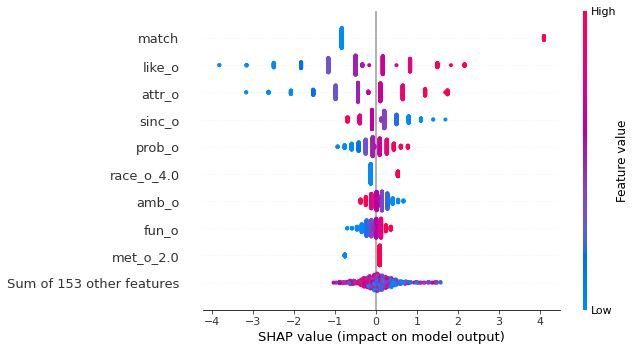

Wall time: 1.12 s


In [111]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.ipynb'
# import shap
import shap
shap.initjs() #%%%%% what is this for?

# Explain the linear model
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns)
logreg_shap_values1 = logreg_explainer1(X_test_mean_scaled_odmb)

# Summarize the effect of all the features
shap.plots.beeswarm(logreg_shap_values1)

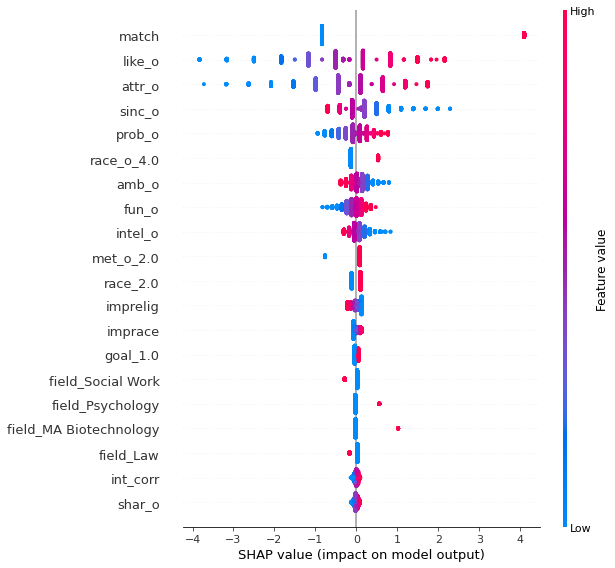

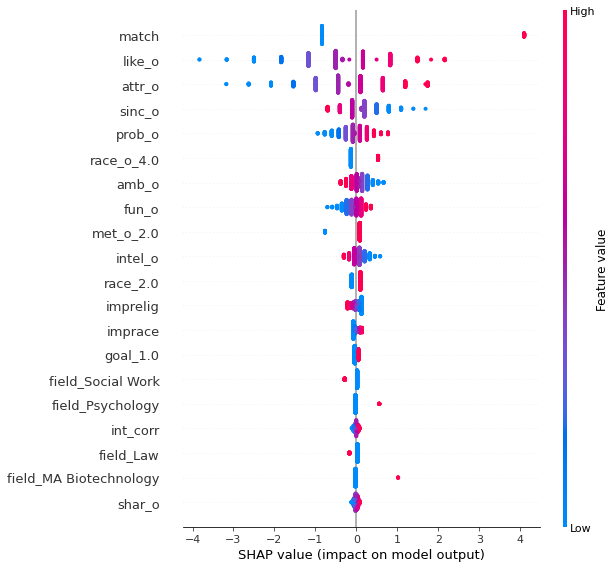

Wall time: 1.67 s


In [112]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values2 = logreg_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values2, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values3 = logreg_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values3, X_test_mean_scaled_odmb)

**shap plot interpretation**
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

Refererence: 'https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a'

sklearn logistic regression model (rated by male partner): TBD

### 3.6.2 LogisticRegression via statsmodel

In [113]:
# use statsmodels.discrete.discrete_model.LogitResults.get_margeff!?

### 3.6.3 Random Forest via sklearn

#### 3.6.3.1 Using shap

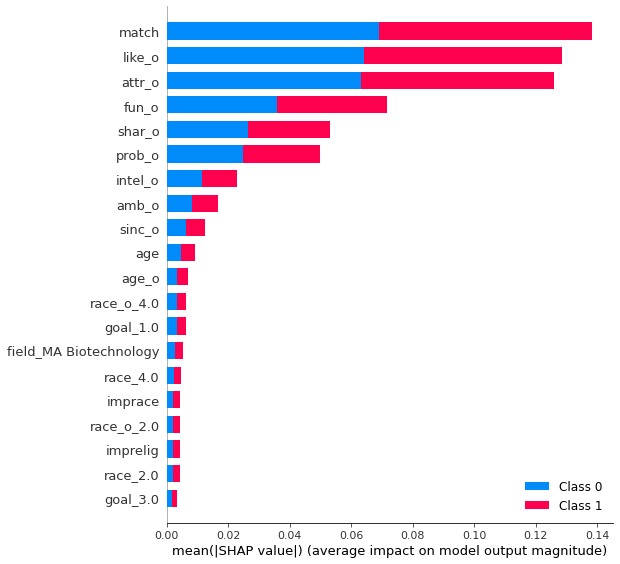

Wall time: 38.6 s


In [114]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.ipynb'
import shap

shap.initjs() #%%%%% what is this for?

# Explain the linear model
rfc_explainer1 = shap.TreeExplainer(rfc_best1, feature_names=X_train_mean_scaled_odmb.columns)
rfc_shap_values1 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb) # this shap value is 'list' object with no

# Summarize the effect of all the features
shap.summary_plot(rfc_shap_values1, X_test_mean_scaled_odmb)

In [115]:
# check size of rfc_y_pred1
rfc_y_pred1 # need to convert this to list with 2 element.

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,

In [116]:
# to count the 0 and 1 in y_pred1_rfc
# refer to 'https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray'
import collections
collections.Counter(rfc_y_pred1)

Counter({1: 290, 0: 336})

In [117]:
# ideally this value should be 0 to make symmetry plot above!?
print(np.abs([np.sum(list(rfc_shap_values1[0])), np.sum(list(rfc_shap_values1[1]))] + rfc_explainer1.expected_value - [780, 474]).max()) 
#%%%% original code was rcf_shap_values.sum(1), but rcf_shap_values is list object that does not have sum attribute.
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max() > this output should be 0 to get symmetry plot.

779.0794287039674


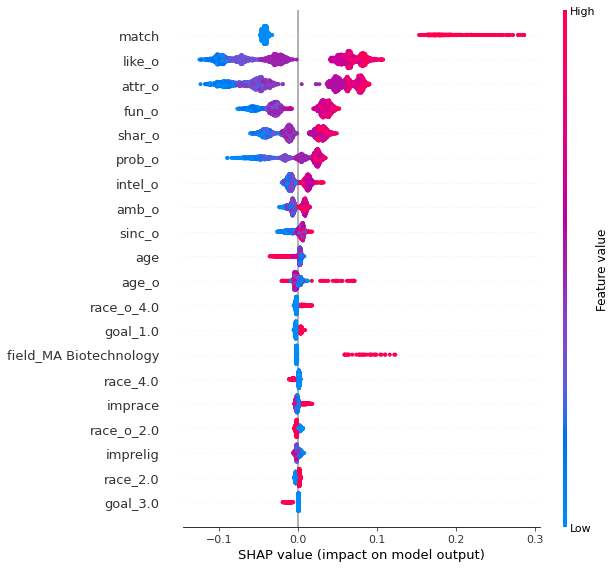

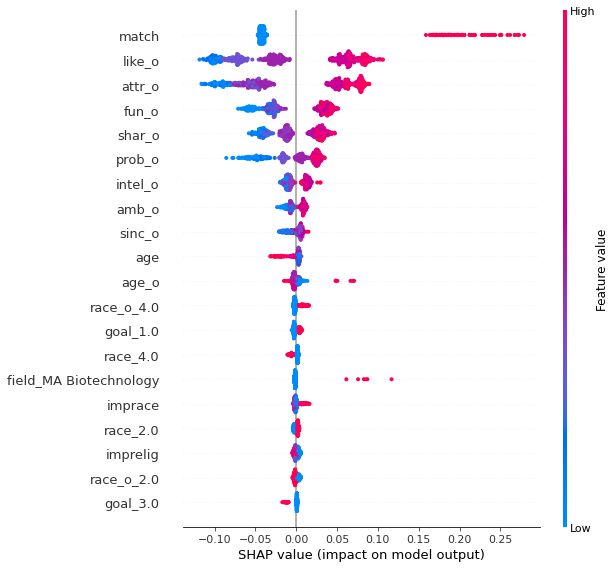

Wall time: 49.3 s


In [118]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values2[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3 = rfc_explainer1.shap_values(X_test_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values3[1], X_test_mean_scaled_odmb)

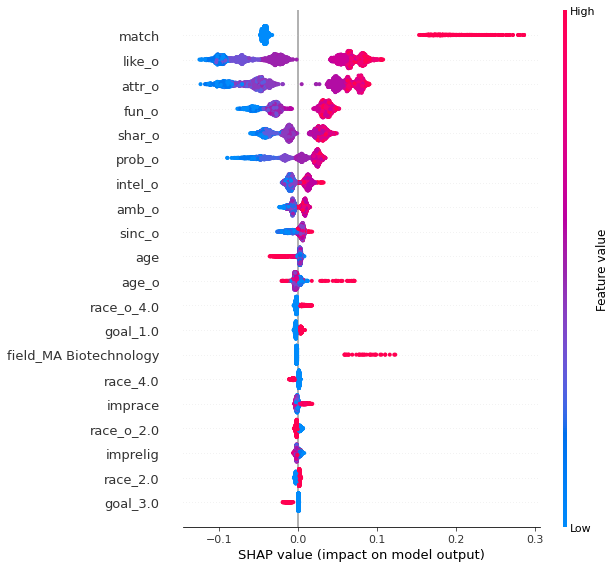

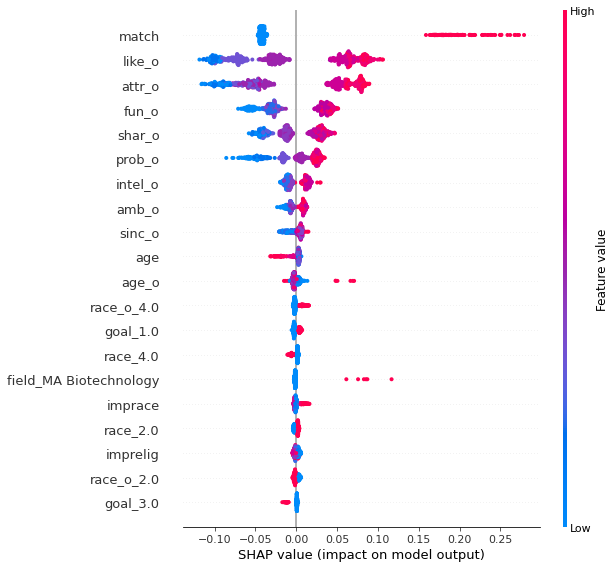

Wall time: 49.5 s


In [119]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2a = rfc_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values2a[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3a = rfc_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values3a[1], X_test_mean_scaled_odmb)

#### 3.6.3.2 Using Sklearn Tree model attribute: feature_importances_ 

30


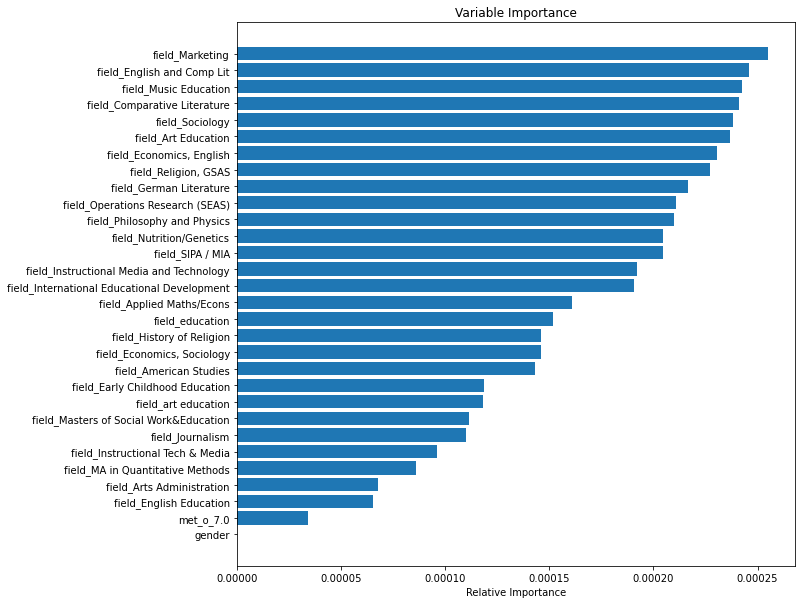

In [120]:
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[:30]
sorted_idx = np.argsort(feature_importance_rfc)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


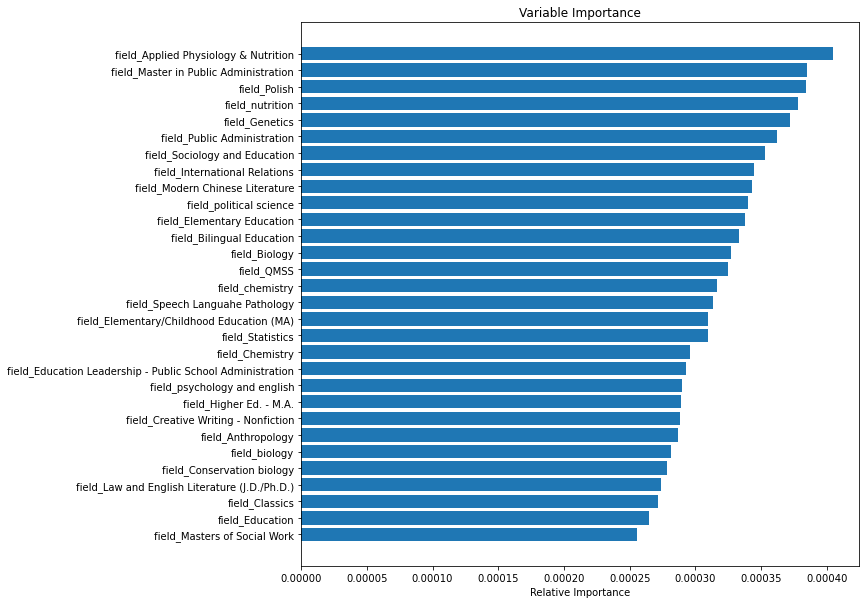

In [121]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[30:60]
sorted_idx = np.argsort(feature_importance_rfc)[30:60]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


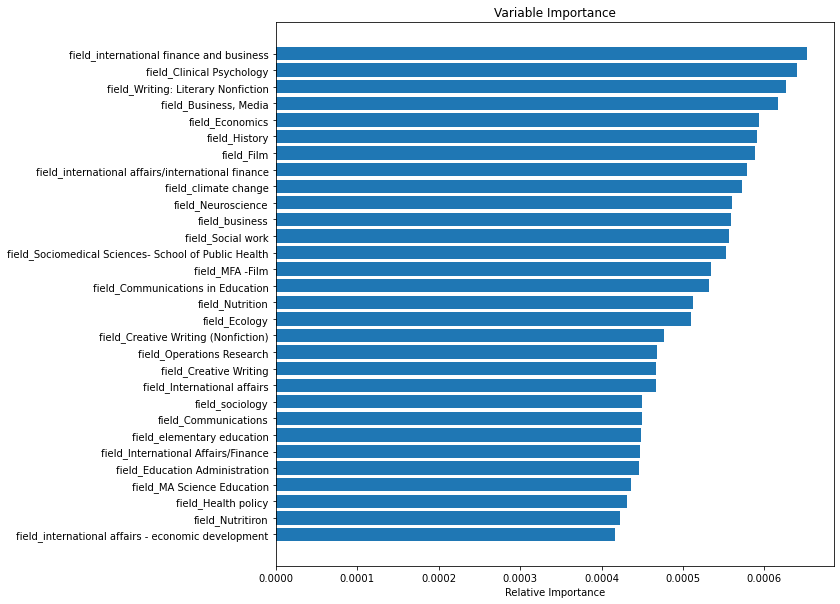

In [122]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[60:90]
sorted_idx = np.argsort(feature_importance_rfc)[60:90]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


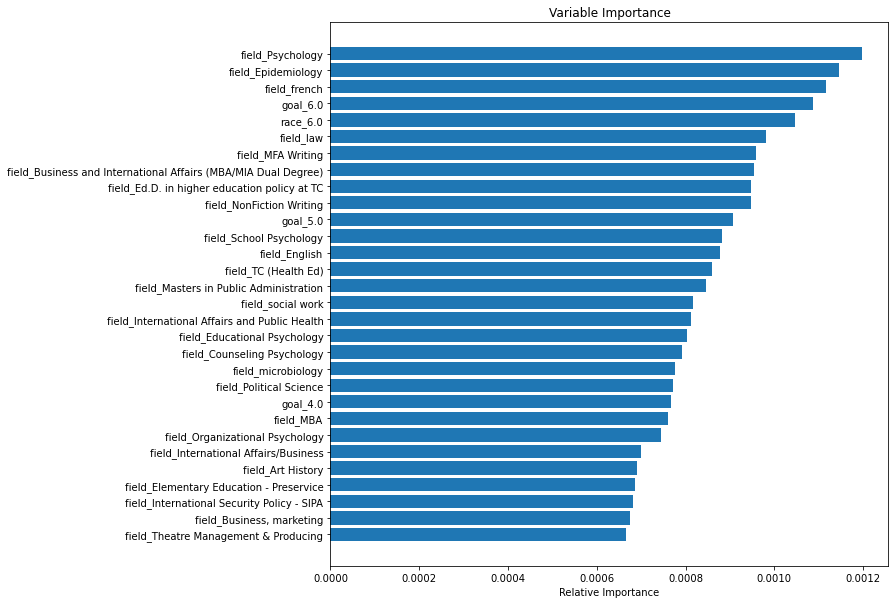

In [123]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[90:120]
sorted_idx = np.argsort(feature_importance_rfc)[90:120]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


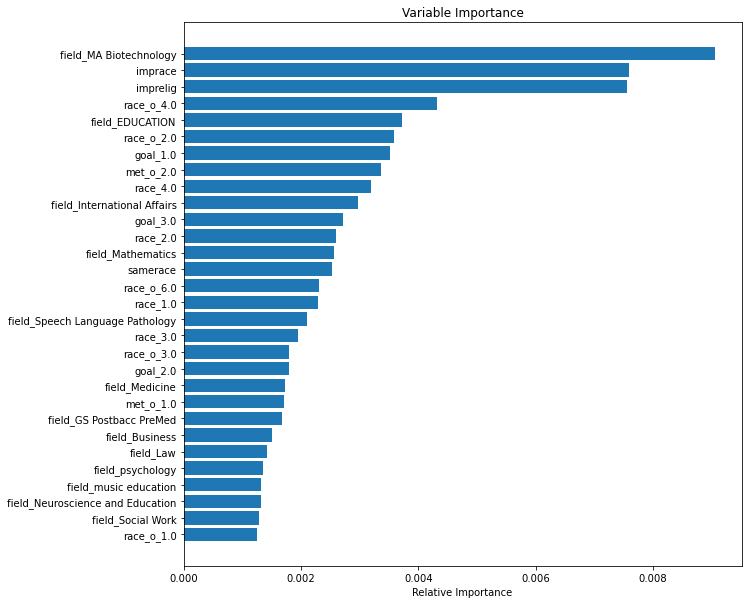

In [124]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[120:150]
sorted_idx = np.argsort(feature_importance_rfc)[120:150]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

12


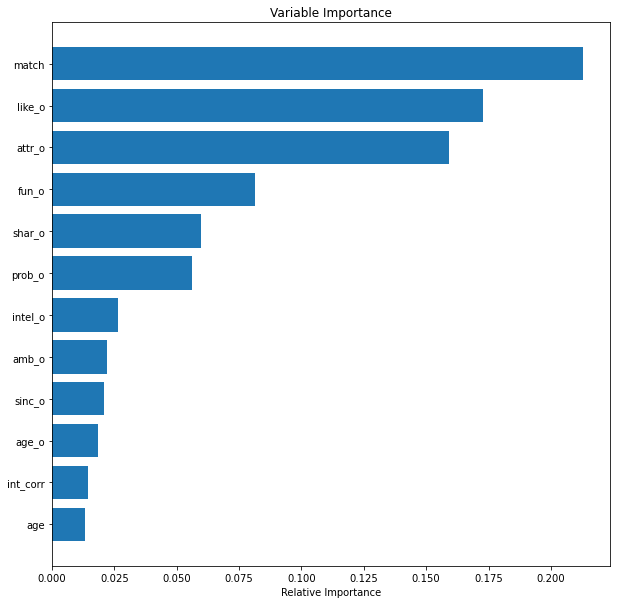

In [125]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[150:180]
sorted_idx = np.argsort(feature_importance_rfc)[150:180]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [128]:
# refer to 'https://ff06-2020.fastforwardlabs.com/'
# to interpret resutls. 

### reference
- sklearn codes:
    - '14.1.2_3_Supervised Learning_Tuning': logisticRegression, confusion_matrix, classification_report, 
    - '14.1.2_4_Supervised Learning with scikit-learn_Preprocessing and Pipeline': buiding pipeline, scaler, get_dummies() 
    - '6_GuidedCapstone/04_preprocessing_and_training_mk': scaler, Random Forest model
     - '14.2.11_Case Study - Logistic Regression/Logistic Regression Advanced Case Study_mk': plot logisticRegression output.
- Statsmodel codes:
    - '11.4.1_Case Study - Linear Regression/Regression Case Study - the Red Wine Dataset - Tier 3_mk': sm.OLS(y, X), plot predictions (y_test vs. y_pred)
- Random Forest model codes:'14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.3.5_Case Study - Decision Trees - RR Diner Coffee/Decision Tree Specialty Coffee Case Study - Tier 3_mk'
    
- refer to 'https://pandas.pydata.org/pandas-docs/version/0.24.0rc1/api/generated/pandas.Series.to_numpy.html'
    - series to numpy: s.to_numpy()
- data preprocessing: 
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk': get_dummies(), sklearn scaler
    - '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk': exctract categorical data
    - '15.4.3_3_Unsupervised Learning_Dimension reduction': PCA
- feature importance interpretation: SHAP
    - https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9
    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    - https://ff06-2020.fastforwardlabs.com/
   

### Questions:
- how do perform cross validation on statsmodel?
    - Answers:
    - currently not avaliable(can't perform cross validation using statsmodels.api yet) and is not compatibible with sklearn cross_val_score or GredSearchCV...etc
    - need to write custom codes if you really want to
    - people usually use sklearn for building ML model.
    - statsmodel is used for quick stats calculation from a model than model optimazation. 
- how to use ElasticNet in sklearn LogisticRegression? (currently only l1 or l2 are available!?)
    - Answers:
    - need to change the default solver (lbfgs) to saga in order to use elasticnet
        - param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 
        - logreg = LogisticRegression(solver='saga', max_iter=10000) 
        - logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
- how to compare the performance of statsmodel and sklearn lotistic model
    - Answers:
    - use sklearn confusion_matrix, classification_report on the y_pred, y_test
    - need to convert the statsmodel's y_pred in probability to binary system (0,1) in advance
    
- how to choose scoring system for GridSearhCV like we can do for cross_val_score? (what is the defaut score?, accuracy?)
    - cv_accuracy = cross_val_score(clf, Xlr, ylr, cv=5, scoring='accuracy')
    - cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
    - Answers:
    - use GridSearhCV(logreg, param_grid, scoring = 'roc_auc', cv=5), default scoring = 'accuracy'
    - should not use 'accuracy' scoring for data with imbalanced disribution.
    - for logistic regression, target variable (0,1), if there is much more (more than 10x!?) 1 than 0 (or vice verso) > imbalanced data
- for logistic regression model, do I need to leave all the binary variable (or only dependent variable) out for scaling.
    - Answers: 
    - leaving it out all the binary viarable for scaling for logistic regression model might be better!?
    - 